# Relevant Segment Extraction (RSE)

## 개요
**Relevant Segment Extraction (RSE)**  는 RAG 시스템에서 검색된 청크들을 원래 문서의 순서에 따라 재구성하는 기법입니다.  
이 방식은 관련성 있는 청크 사이에 위치한 **낮은 관련성 청크**도 함께 포함해 더 풍부한 문맥을 제공합니다.  
이를 통해 **RAG 성능**과 **LLM 응답 품질**을 향상시킵니다.

- **작은 청크**: 특정 정보 검색에 유리하지만 문맥이 부족할 수 있음  
- **큰 청크**: 문맥 제공에 유리하지만 정확성 저하 가능  

RSE는 이러한 한계를 해결하기 위해, **관련 청크들이 원래 문서에서 서로 가까이 위치해 있음**이라는 특성을 활용

---

## 주요 구성 요소
- **청크 텍스트 키-값 저장소**: 문서 ID와 청크 인덱스를 키로 사용해 빠르게 청크 데이터를 검색  
- **연속적 청크 연결**: 중첩 없이 분할된 청크를 기반으로 연속적 문맥을 재구성  


## RSE 최적화
- 검색된 청크의 **유사도 점수**와 **순위**를 결합해 초기 점수 산출  
- 각 청크 점수에서 일정 임계값(예: 0.2)을 차감해 다음과 같이 점수를 할당  
  - 관련성 낮은 청크 → 음수 점수  
  - 관련성 높은 청크 → 양수 점수  
- 최종 세그먼트 점수는 **포함된 청크 점수의 합**으로 계산  
- 최대합 부분 배열 알고리즘 (Kadane’s Algorithm)과 유사한 방식으로 효율적 탐색  

## 예시
청크 값이 `[-0.2, -0.2, 0.4, 0.8, -0.1]`일 경우:  
- 청크 2-3만 포함된 세그먼트 점수 = `0.4 + 0.8 = 1.2`

## 장점
- **정확성 향상**: 관련 청크 외에 문맥적으로 중요한 청크 추가  
- **응답 품질 개선**: 복잡한 질문에서도 충분한 문맥 제공  
- **효율성**: 5~10ms 내에 빠르게 최적 세그먼트 검색  



![Relevant segment extraction](../images/relevant-segment-extraction.svg)


# Setup
First, some setup. You'll need a Cohere API key to run some of these cells, as we use their excellent reranker to calculate relevance scores.

In [1]:
import os
import numpy as np
from typing import List
from scipy.stats import beta
import matplotlib.pyplot as plt
import cohere
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()
os.environ["CO_API_KEY"] = os.getenv('CO_API_KEY') # Cohere API key

- 청크에 대한 관련성 값을 계산하기 위해 Cohere Rerank API를 사용하겠습니다. 
- 일반적으로는 벡터 및/또는 키워드 검색으로 시작하여 후보 목록을 좁히지만, 여기서는 단일 문서만 다루기 때문에 모든 청크를 리랭커로 직접 전송하여 작업을 조금 더 간단하게 유지할 수 있습니다.

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 청크 split 함수 
def split_into_chunks(text: str, chunk_size: int):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0, length_function=len)
    texts = text_splitter.create_documents([text])
    chunks = [text.page_content for text in texts]
    return chunks


# 이 함수는 Cohere Rerank API가 반환한 유사도 점수를 0과 1 사이의 균일한 분포 값으로 변환합니다.
def transform(x: float):
    """
    Transformation function to map the absolute relevance value to a value that is more uniformly distributed between 0 and 1. 
    The relevance values given by the Cohere reranker tend to be very close to 0 or 1. This beta function used here helps to spread out the values more uniformly.

    Args:
        x (float): The absolute relevance value returned by the Cohere reranker

    Returns:
        float: The transformed relevance value
    """
    a, b = 0.4, 0.4  # These can be adjusted to change the distribution shape
    return beta.cdf(x, a, b)


# 쿼리와 청크리스트를 받아서 
def rerank_chunks(query: str, chunks: List[str]):

    model = "rerank-english-v3.0"
    client = cohere.Client(api_key=os.environ["CO_API_KEY"])
    decay_rate = 30

    # 쿼리와 리스트 간의 유사도 계산 => 높은 순대로 리랭킹 
    reranked_results = client.rerank(model=model, query=query, documents=chunks)
    results = reranked_results.results 

    # 인덱스와 유사도 반환 
    reranked_indices = [result.index for result in results]
    reranked_similarity_scores = [result.relevance_score for result in results] 
    
    # 유사도 점수와 해당 인덱스 
    similarity_scores = [0] * len(chunks)
    chunk_values = [0] * len(chunks)  # 높은 순대로 정렬 
 
    # 여기서 인덱스순으로 정리하기 때문에 관련도 점수 정렬이 내림차순이 안됌 
    for i, index in enumerate(reranked_indices):
        absolute_relevance_value = transform(reranked_similarity_scores[i]) # 유사도 점수를 0과1 사이의 값으로 반환 
        similarity_scores[index] = absolute_relevance_value # 유사도 리스트에 저장
        # 순위가 높을수록 높은 가중치 계산하여 넣기 => 유사도 곱하기 가중치 
        chunk_values[index] = np.exp(-i/decay_rate)*absolute_relevance_value 

    return similarity_scores, chunk_values

# 인덱스별로 순위를 고려한 유사도 값 
def plot_relevance_scores(chunk_values: List[float], start_index: int = None, end_index: int = None) -> None:
    plt.figure(figsize=(12, 5))
    plt.title(f"Similarity of each chunk in the document to the search query")
    plt.ylim(0, 1)
    plt.xlabel("Chunk index")
    plt.ylabel("Query-chunk similarity")
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(chunk_values)
    plt.scatter(range(start_index, end_index), chunk_values[start_index:end_index])

In [14]:
client = cohere.Client(api_key=os.environ["CO_API_KEY"])
reranked_results = client.rerank(model="rerank-english-v3.0", query=query, documents=chunks)
results = reranked_results.results
reranked_indices = [result.index for result in results]
reranked_similarity_scores = [result.relevance_score for result in results] 
reranked_similarity_scores

[0.99549675,
 0.9948001,
 0.9922444,
 0.9922444,
 0.9890976,
 0.984516,
 0.9755769,
 0.9695556,
 0.9667888,
 0.9649213,
 0.95565146,
 0.9513234,
 0.93171144,
 0.93108755,
 0.90397453,
 0.9034647,
 0.9032942,
 0.90000373,
 0.89982784,
 0.89218736,
 0.891811,
 0.8834373,
 0.8692713,
 0.85195273,
 0.82587075,
 0.8161134,
 0.81257004,
 0.80837,
 0.80147004,
 0.7977145,
 0.7601169,
 0.7426084,
 0.71552336,
 0.713132,
 0.7112304,
 0.6737286,
 0.6686639,
 0.65907604,
 0.6550051,
 0.6225741,
 0.61103386,
 0.6036398,
 0.59930927,
 0.5672176,
 0.56385833,
 0.55679125,
 0.5500032,
 0.54849213,
 0.5357665,
 0.5297956,
 0.5189576,
 0.5061833,
 0.50207895,
 0.4862019,
 0.4853405,
 0.48500514,
 0.47846788,
 0.47271392,
 0.45774263,
 0.4458311,
 0.42036164,
 0.417984,
 0.4128852,
 0.41182032,
 0.41004738,
 0.40933883,
 0.38867602,
 0.38722676,
 0.3765085,
 0.34466398,
 0.3309035,
 0.32734567,
 0.31373507,
 0.31027624,
 0.3060083,
 0.30218512,
 0.29685807,
 0.28666824,
 0.28646857,
 0.27923846,
 0.2730

In [15]:
# File path for the input document
FILE_PATH = "../data/nike_2023_annual_report.txt"

with open(FILE_PATH, 'r') as file:
    text = file.read()

chunks = split_into_chunks(text, chunk_size=800)

print (f"Split the document into {len(chunks)} chunks")

Split the document into 500 chunks


# Visualize chunk relevance distribution across single document

In [16]:
# Example query that requires a longer result than a single chunk
query = "Nike consolidated financial statements"

similarity_scores, chunk_values = rerank_chunks(query, chunks)

In [8]:

similarity_scores
# chunk_values

[0.276442805184001,
 0.09860185980566533,
 0.03579673263324868,
 0.055680414818015514,
 0.06029077743451332,
 0.4503861970932181,
 0.03962101500165452,
 0.3748132762992908,
 0.48829053369152653,
 0.27614561096143614,
 0.055854419325538925,
 0.033839664799481625,
 0.12229296031180101,
 0.15369915846467597,
 0.10218497789321433,
 0.17902850776822163,
 0.2407957844891862,
 0.1846809339734992,
 0.1982647472632864,
 0.16553067380894831,
 0.2738754239205785,
 0.04139164138215389,
 0.05190504870226534,
 0.20051469108083644,
 0.1723526589719565,
 0.14060543011390236,
 0.14103859269695398,
 0.1801186907619063,
 0.032594698268520676,
 0.08375524616104578,
 0.045314575887559556,
 0.05744500484203276,
 0.10738372701805249,
 0.1870725766255557,
 0.07510865925886243,
 0.052803671984075325,
 0.032645646659076495,
 0.044892121498188504,
 0.03421164755648897,
 0.25999775713146345,
 0.044473600022049864,
 0.02627433318007745,
 0.07002377095878395,
 0.07534296440826832,
 0.04204296972690031,
 0.079068771

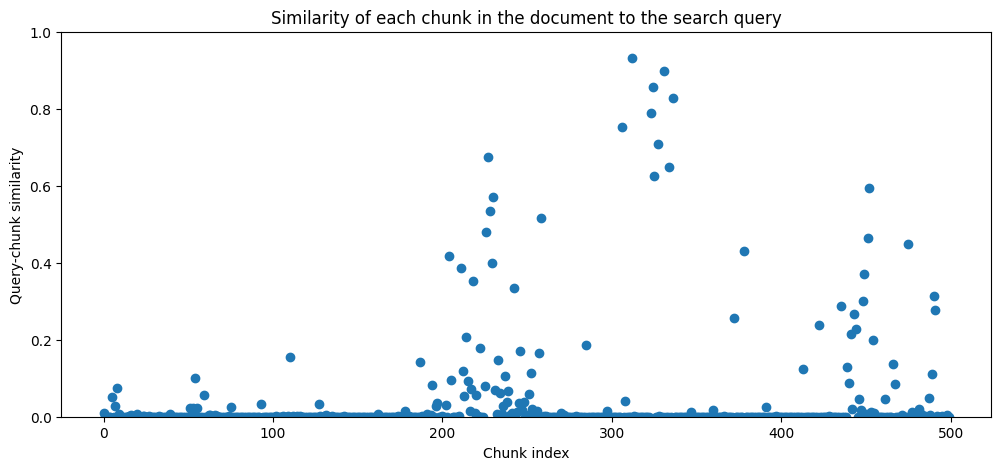

In [17]:
plot_relevance_scores(chunk_values)

### 위의 청크 관련성 플롯을 해석하는 방법
- 위 그림에서 X축은 청크 인덱스를 나타냄. 문서의 첫 번째 청크는 인덱스 0, 다음 청크는 인덱스 1. Y축은 쿼리에 대한 각 청크의 관련성을 나타냄
- 이런 식으로 보면 관련성 있는 청크가 문서의 하나 이상의 섹션에서 어떻게 클러스터링되는 경향이 있는지 알 수 있습니다. 
### 확대하기


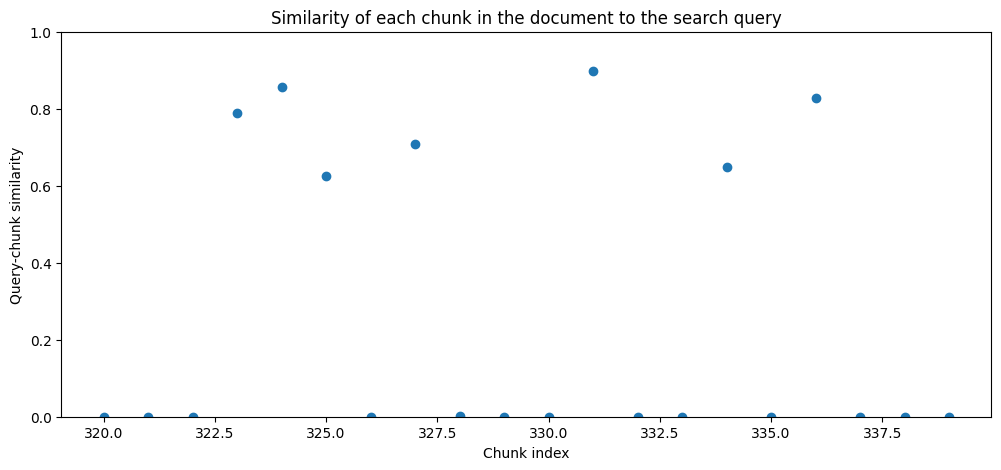

In [18]:
plot_relevance_scores(chunk_values, 320, 340)


- 20개중 7개가 관련 높아 보임
- 특히 323에서 336 사이는 절반 이상이 관련 높아 보임 

### Let's see what this part of the document contains

In [20]:
# 320과 340 사이 문서들 확인 
def print_document_segment(chunks: List[str], start_index: int, end_index: int):
    for i in range(start_index, end_index):
        print(f"\nChunk {i}")
        print(chunks[i])

print_document_segment(chunks, 320, 340)


Chunk 320
financial statements, taken as a whole, and we are not, by communicating the critical audit matter below , providing a separate 
opinion on the critical audit matter or on the accounts or disclosures to which it relates.
Accounting for Income Taxes
As described in Notes 1 and 7 to the consolidated financial statements, the Company recorded income tax expense of $1,131 
million for the year ended May 31, 2023, and has net deferred tax assets of $1,799 million, including a valuation allowance of $22 
million, and total gross unrecognized tax benefits, excluding related interest and penalties, of $936 million as of May 31, 2023, 
$651 million of which would affect the Company's effective tax rate if recognized in future periods. The realization of deferred tax

Chunk 321
assets is dependent on future taxable earnings. Management assesses the scheduled reversal of deferred tax liabilities, 
projected future taxable income and available tax planning strategies and considers forei

1. 문제: 리랭커가 모든 관련 청크를 잡아내지 못함
- 예를 들어, 손익계산서가 청크 323에서 시작해 청크 333까지 이어져 있다고 가정합니다. 이 구간 전체가 우리가 찾고 있는 연결된 재무제표를 포함하고 있어 쿼리에 완전히 부합하는 정보입니다. 그러나 리랭커는 이 구간의 약 절반 정도의 청크만 관련이 있는 것으로 표시했습니다. 따라서, 일부 중요한 청크가 검색 결과에서 제외될 위험이 있습니다.

- 이 문제는 다음과 같은 이유로 인해 발생할 수 있습니다:

- 리랭커가 청크의 개별 정보만 평가하기 때문에, 관련 청크들이 실제 문서 내에서 서로 인접해 있음을 고려하지 못합니다.
- 개별 청크가 쿼리와 덜 유사해 보일 수 있지만, 연속된 청크들이 쿼리와 관련 있는 전체적인 문맥을 제공하는 경우도 많습니다.
- 이러한 문제를 해결하기 위해 인접한 관련 청크들을 그룹화하여 LLM에 제공할 필요가 있습니다. 이 방식은 관련성 있는 청크들이 클러스터 형태로 결합되어 보다 완전한 문맥을 전달하게 됩니다.

### What can we do with these clusters of relevant chunks?
1. 해결책: 관련 청크 클러스터 찾기
핵심 아이디어는 원래 문서에 등장하는 순서대로 청크를 연속적으로 연결하는 것이 LLM에 더 나은 문맥을 제공한다는 것입니다. 즉, 서로 인접한 관련 청크들을 한데 묶어 LLM에 제공하는 것이 개별 청크를 제공하는 것보다 훨씬 유리합니다.

그러나 실제로 이런 관련 청크의 클러스터를 어떻게 찾을 것인가? 하는 문제가 남아 있습니다. 이를 위해, 각 청크의 가치를 수치화하여 특정 구간의 청크들이 합쳐졌을 때 그 구간의 가치가 더해지도록 계산할 수 있습니다. 이 접근법을 통해 최적의 구간을 찾는 문제는 `최대 부분 배열 문제(Maximum Subarray Problem)`
로 변환됩니다.

2. 청크 값 정의 방법

- 높은 관련성 점수를 가진 청크는 긍정적인 영향을 미친다고 보고 높은 값을 할당합니다.
- 낮은 관련성 점수를 가진 청크는 부정적인 영향을 미친다고 보고 낮은 값을 할당합니다.
- Cohere 리랭커가 청크에 대해 0에서 1 사이의 관련성 점수를 제공하고 있으므로, 0.2 정도의 상수 값을 뺀 후 청크 값을 정하는 방식을 사용할 수 있습니다. 이 상수를 irrelevant_chunk_penalty라고 부르며, 경험적으로 0.2 정도의 값이 적합합니다.


예를 들어:

- 관련성 점수가 0.4인 청크에 0.2를 빼면 청크 값은 0.2가 됩니다(관련 청크로 간주).
- 관련성 점수가 0.1인 청크에 0.2를 빼면 청크 값은 -0.1이 됩니다(비관련 청크로 간주).
- 이렇게 계산된 청크 값들로 구성된 구간의 값은 그 구간의 청크 값들의 합으로 정의할 수 있습니다. 이 방법을 통해 최적의 구간을 찾는 문제를 최대 부분 배열 문제로 바꿀 수 있으며, 이 문제는 효율적으로 해결할 수 있습니다.

즉, 0.2를 빼는 이유는 유사도 점수가 낮아 관련성이 없는 청크를 음수 값으로 바꿔서, 이러한 청크들이 최적의 구간을 찾는 과정에서 자연스럽게 제외되도록 하기 위해서입니다. 이를 통해, 관련성이 높은 청크들로만 구성된 구간을 찾아낼 수 있다.

In [21]:
len(chunk_values)

500

In [22]:

# 최적 구간 탐색 함수 
def get_best_segments(relevance_values: list, max_length: int, overall_max_length: int, minimum_value: float):
    best_segments = [] # 최종 선택된 구간 
    scores = [] # 총 점수 
    total_length = 0 # 선택된 구간의 길이 

    # 최적 구간 탐색  0~500
    while total_length < overall_max_length:
        # find the best remaining segment
        best_segment = None
        best_value = -1000
        for start in range(len(relevance_values)):
            # 음수 구간은 지나감 
            if relevance_values[start] < 0: 
                continue
            # start부터 500까지 하는데 음수가 발생하면 멈춤 
            for end in range(start+1, min(start+max_length+1, len(relevance_values)+1)):
                if relevance_values[end-1] < 0:
                    continue
                # 선택된 구간과 겹치면 건너뜀 
                if any(start < seg_end and end > seg_start for seg_start, seg_end in best_segments):
                    continue
                # 설정한 20보다 구간이 커지면 건너뜀 
                if total_length + end - start > overall_max_length:
                    continue
                
                # start end 사이의 값을 합해서 새로운 변수에 추가 
                segment_value = sum(relevance_values[start:end])
                # 높은 점수라면 갱신 
                if segment_value > best_value:
                    best_value = segment_value
                    best_segment = (start, end)
        
        # if we didn't find a valid segment then we're done
        if best_segment is None or best_value < minimum_value:
            break
        
        # 최적구간 탐색종료 
        best_segments.append(best_segment)
        scores.append(best_value)
        total_length += best_segment[1] - best_segment[0]
    
    return best_segments, scores

In [23]:
# define some parameters and constraints for the optimization
irrelevant_chunk_penalty = 0.2 # empirically, something around 0.2 works well; lower values bias towards longer segments
max_length = 20
overall_max_length = 30
minimum_value = 0.7

# 0.2 뺀 값들 로 새로운 리스트 생성 
relevance_values = [v - irrelevant_chunk_penalty for v in chunk_values] 

# run the optimization
best_segments, scores = get_best_segments(relevance_values, max_length, overall_max_length, minimum_value)

# print results
print ("Best segment indices")
print (best_segments) # indices of the best segments, with the end index non-inclusive
print ()
print ("Best segment scores")
print (scores)
print ()

Best segment indices
[(323, 337), (226, 231), (448, 453), (312, 313)]

Best segment scores
[2.555989540452021, 1.656925736465827, 0.7325434565515304, 0.7318070628222588]



# 최적 세그먼트와 단일 청크에 대한 답변 처리 방법

## 1. 최적 세그먼트 선택
최적화 알고리즘은 쿼리에 가장 관련성 높은 **연속된 청크**들을 모아 최적의 세그먼트를 선택한다.  
예를 들어, 알고리즘이 청크 323~336 구간을 선택했지만, 실제로는 청크 323~333만이 이상적인 세그먼트로 확인될 수 있다.

- **추가 청크 포함**: 최적화 과정에서 필요 이상의 청크(예: 334~336번 청크)가 포함될 수 있지만, 이런 청크들이 문맥을 파악하는 데 유용할 경우 유익하게 작용할 수 있다.  
- **짧은 세그먼트 확인**: 문서의 다른 부분에서 짧은 청크가 더 적절할 경우, 해당 청크만 별도로 전달하는 것도 가능하다.


## 2. 단일 청크에만 답이 있는 경우
어떤 질문은 단일 청크나 서로 연속적이지 않은 소수의 청크에만 답이 포함될 수 있다. 이 경우, 큰 세그먼트를 만들 필요 없이 해당 청크들만 반환하는 것이 효율적이다. RSE는 이를 효과적으로 처리할 수 있다.

- **단일 청크 또는 비연속 청크**: 관련성 있는 연속된 청크가 없는 경우, RSE는 단순히 top-k 검색처럼 작동하여 관련성 높은 청크들만 반환한다.  
- **효율적인 문맥 제공**: 이 방법을 통해 LLM에 필요한 정보만을 효율적으로 전달할 수 있다.

## 3. 청크 관련성 플롯과 최적 세그먼트 비교
단일 청크나 비연속적인 청크가 관련이 있을 때는 **청크 관련성 플롯**에서 높은 관련성의 개별 청크들만 눈에 띄게 된다.  
이 경우, 최적화 알고리즘은 작은 구간이나 개별 청크를 반환하여 LLM이 쿼리에 필요한 정확한 정보를 얻도록 한다.

## 4. 단일 청크만 선택되도록 하기 위한 방법
RSE가 단일 청크를 반환하도록 하려면, 해당 청크만이 관련성이 높은 것으로 선택되도록 유도해야 한다.  
이를 위해 다음과 같은 방법을 사용할 수 있다.

1. **음수 페널티(`irrelevant_chunk_penalty`) 적용**  
   - 연속된 청크들 중에서 비관련성 청크에 대해 음수 페널티를 적용하여, 단일 청크만 양수 관련성 값을 가지게 한다.

2. **최소 관련성 점수 설정**  
   - `minimum_value`를 설정하여, 단일 청크의 점수가 이를 충족할 때만 해당 청크가 선택되도록 한다.

이렇게 하면 단일 청크가 관련성이 있는 경우 주변 청크들이 자동으로 제외되도록 하여, 정확한 정보만 LLM에 전달할 수 있다.


# 평가 결과

### KITE
RAG 성능 평가를 위해 자체 제작한 벤치마크인 [KITE](https://github.com/D-Star-AI/KITE) (Knowledge-Intensive Task Evaluation)에서 RSE의 성능을 평가했습니다. 

KITE는 현재 총 4개의 데이터셋과 50개의 질문으로 구성되어 있습니다.
- **AI Papers**: AI와 RAG에 관한 약 100개의 학술 논문 (PDF 형식, arXiv에서 다운로드)
- **BVP Cloud 10-Ks**: Bessemer Cloud Index에 속하는 모든 기업의 10-K 보고서 약 70개 (PDF 형식)
- **Sourcegraph Company Handbook**: Sourcegraph의 공개된 회사 핸드북 GitHub [페이지](https://github.com/sourcegraph/handbook/tree/main/content)에서 다운로드한 약 800개의 마크다운 파일 및 원래 디렉토리 구조
- **Supreme Court Opinions**: 미국 대법원 2022년 연도의 모든 의견서 (2023년 1월~6월 발행, PDF 형식, [공식 웹사이트](https://www.supremecourt.gov/opinions/slipopinion/22)에서 다운로드)

각 샘플에는 정답이 포함되어 있으며, 대부분의 샘플에는 평가 기준도 함께 제공됩니다. 질문 당 0-10점의 점수를 부여하며, 강력한 성능을 가진 LLM을 통해 평가를 수행했습니다.

RSE의 성능은 **기본 Top-k 검색 방식**(k=20)과 비교했습니다. 다른 매개변수는 두 설정 간 동일하게 유지했습니다. 검색에 **Cohere 3 리랭커**를 사용했고, 답변 생성에는 **GPT-4o**를 사용했습니다. 두 설정 간의 관련 정보 문자열 길이가 거의 동일하기 때문에, **비용과 지연 시간** 또한 유사합니다.

| 데이터셋                  | Top-k    | RSE    |
|-------------------------|----------|--------|
| AI Papers               | 4.5      | 7.9    |
| BVP Cloud               | 2.6      | 4.4    |
| Sourcegraph             | 5.7      | 6.6    |
| Supreme Court Opinions  | 6.1      | 8.0    |
| **평균**                 | 4.72     | 6.73   |

이 표에서 RSE가 네 개의 데이터셋 모두에서 성능을 향상시키는 것을 확인할 수 있습니다. **평균 점수**는 4.72에서 6.73으로 증가하여, 성능이 **42.6% 향상**되었습니다.

---

### FinanceBench
RSE는 FinanceBench에서도 평가되었습니다. 여기에서 RSE는 **83%의 점수**를 기록했으며, 이는 **19%의 기본 점수**와 비교됩니다. FinanceBench에서는 **Contextual Chunk Headers (CCH)**와 RSE를 함께 테스트했으므로, 정확히 RSE만의 성능 기여도를 따로 평가할 수는 없었지만, **CCH와 RSE를 함께 사용한 경우 정확도가 크게 향상됨**을 확인했습니다.

---
